# Curso de Capacitación en Python para Data Science - Desafío 6

<img src='https://escuela.pucp.edu.pe/gobierno/wp-content/uploads/2015/04/logo-pucp-full-color-300x88.png' width=200px>


Dr. Edwin Villanueva, Dra. Soledad Espezua, Ing. Daniel Saromo

<font color='#33FFEE'> Clasificación de datos en Python.</font>

Completar con su código los campos requeridos y subir su notebook solucionado a la plataforma PAIDEIA. El formato del nombre del notebook es: `Desafio6_APELLIDOPATERNO_NOMBRE.ipynb`.

Es responsabilidad del alumno verificar que el archivo que subió es el correcto. Respetar los lineamientos de la entrega de archivo, ya que influirá en su calificación. La fecha límite de entrega del presente desafío se encuentra en PAIDEIA. No se aceptarán entregas luego de haberse publicado el solucionario de la tarea.

## Desafío de la semana <font color=red> (20 puntos) </font>

In [1]:
# Cargar libreriras y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest   # para seleccionar atributos de forma univariada (filtros)
from sklearn.feature_selection import chi2   # estadististica para evaluar la importancia de atributos en relacion al target
from sklearn.feature_selection import RFE    # metodo recursive featute elimination
from sklearn.decomposition import PCA        # para transformacion PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # para modelos discriminantes lineales
from sklearn.naive_bayes import GaussianNB   # para modelos Naive Bayes
from sklearn.linear_model import LogisticRegression # para usar modelos de regresion logistica  
from sklearn.tree import DecisionTreeClassifier     # para usar modelos de tipo arboles de decision
from sklearn.neighbors import KNeighborsClassifier  # para modelos  Knn 
from sklearn.svm import SVC   # para modelos SVM

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion 

from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño 
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion

###  Dataset

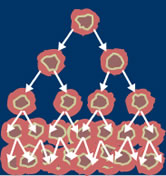

Se tiene el dataset BreastTumors.xlsx (tomado de https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29), el cual contiene diferentes características de muestras celulares de masa mamária y su correspondiente diagnóstico ('benigno', 'maligno'). Las características fueron calculadas a partir de una imagen digitalizada de la muestra celular extraída por aspiración con aguja fina. Los atributos describen las siguientes características de los núcleos celulares presentes en la imagen:  

- radius (promedio de las distancias desde el centro a los puntos de la periferia)
- texture (desviación estándar de los valores en escala de grises)
- perimeter
- area
- smoothness (variación local de las longitudes de los radios)
- compactness (perimeter^2 / area - 1.0)
- concavity (severidad de las porciones cóncavas del contorno)
- concave points (número de porciones cóncavas del contorno)
- symmetry
- fractal dimension ("coastline approximation" - 1)

Para cada una de esas características se ha tomado la media, la desviación estándar y "peor" valor (media de los tres valores más grandes), resultando en 30 atributos. La ultima columna indica el diagnóstico ('benigno', 'maligno')   

In [2]:
# carga el dataset 'BreastTumors.xlsx' 
dataset = pd.read_excel('https://github.com/DanielSaromo/Courses_DataFiles/blob/main/P4DS_CETAM/BreastTumors.xlsx?raw=true',index_col=0)

In [3]:
# muestra la distribucion de las clases
print(dataset.groupby('diagnostico').size())

diagnostico
benigno    212
maligno    357
dtype: int64


In [4]:
dataset.shape

(569, 31)

In [5]:
dataset.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [6]:
# separa el dataset en atributos (X)  y  target (y) 
array = dataset.values    #  extrae el array de valores del dataframe  
array = np.nan_to_num(array)   # reemplaza valores NaN  con 0 

In [7]:
X = array[:,0:30]  # atributos
y = array[:,30]    # target     

### Preguntas

#### 1) Entrenamiento de 4 algoritmos de clasificación aplicando CV de 10 folds: <font color='red'>3 puntos</font>

Hacer un split de los datos en 80% para entrenamiento y 20% para validacion. Con los datos de entrenamiento evaluar en crossvalidacion (10 folds) los siguientes algoritmos: LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier y SVC . La evaluacion debe debe ser hecha tomando en cuenta el desbalance de los datos (Debe usar argumento `scoring='balanced_accuracy'` en la funcion cross_val_score() ).

**Para todos los CV del presente notebook, use `seed=7`.**

In [8]:
# realiza el train-test split
test_size = 0.20
seed = 7
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=seed)      

print('Training: %d ejemplos. Validation: %d ejemplos' % (len(y_train), len(y_valid)))

Training: 455 ejemplos. Validation: 114 ejemplos


In [9]:
# Definimos el pool de algoritmos de ML a evaluar
algos = []
algos.append(('LR', LogisticRegression(solver='liblinear')))
algos.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
algos.append(('CART', DecisionTreeClassifier(max_depth=None)))
algos.append(('SVM', SVC()))

In [10]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

seed = 7   
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)

#  evalua cada algoritmo
for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

LR: 0.9524564973828614 (0.03692742187813586)
KNN: 0.9328956326768558 (0.05295364607623663)
CART: 0.9200196692140352 (0.033023327399567926)
SVM: 0.886299649875362 (0.0634274512386745)


#### 2) Mostrar boxplots de los resultados de `balanced_accuracy` de crossvalidacion e identificar el algoritmo mas adecuado: <font color='red'>1 punto</font>

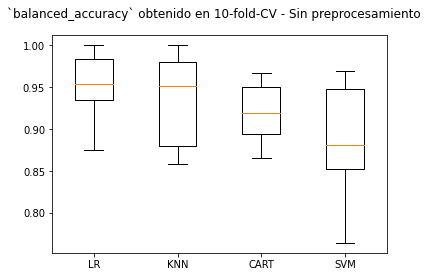

In [11]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure()
fig.suptitle('`balanced_accuracy` obtenido en 10-fold-CV - Sin preprocesamiento')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### 3) Usando toda la data de entrenamiento, ajuste un modelo con el algoritmo identificado en el paso anterior. Además, muestre los resultados indicados: <font color='red'>3 puntos</font>

Entrene un modelo con el algoritmo identificado en la pregunta 2, usando toda la data de entrenamiento. Se quiere que el modelo resultante tenga similares desempeños de prediccion en las dos clases (Tip: Para lograr ello, usar `class_weight = 'balanced'` como argumento del algoritmo).

In [12]:
# Reentrena modelo Logistic Regression con todos los datos de entrenamiento y lo prueba en el conjunto de validación
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)

y_predicted = model.predict(X_valid)

Muestre el balanced accuracy score, la matriz de confusión y el reporte de clasificación en validación:

In [19]:
# predice la clase del conjunto de validacion
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
print("Matriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("Reporte de clasificacion en conjunto de validacion:")
print(classification_report(y_valid, y_predicted, digits=3))

Balanced Accuracy score: 0.9375
Matriz de Confusión:
[[35  5]
 [ 0 74]]
Reporte de clasificacion en conjunto de validacion:
              precision    recall  f1-score   support

     benigno      1.000     0.875     0.933        40
     maligno      0.937     1.000     0.967        74

    accuracy                          0.956       114
   macro avg      0.968     0.938     0.950       114
weighted avg      0.959     0.956     0.955       114



#### 4) Según los resultados de la matriz de confusión, calcule manualmente el valor de la especificidad (specificity) y la sensiblidad (sensitivity). Verifique sus cálculos, comparándolos con los valores que arroja el reporte de clasificación: <font color='red'>1 punto</font>

Para esta parte, de la matriz de confusión generada por la librería sklearn, se deben identificar cuáles son los TP, FP, TN, y FN.

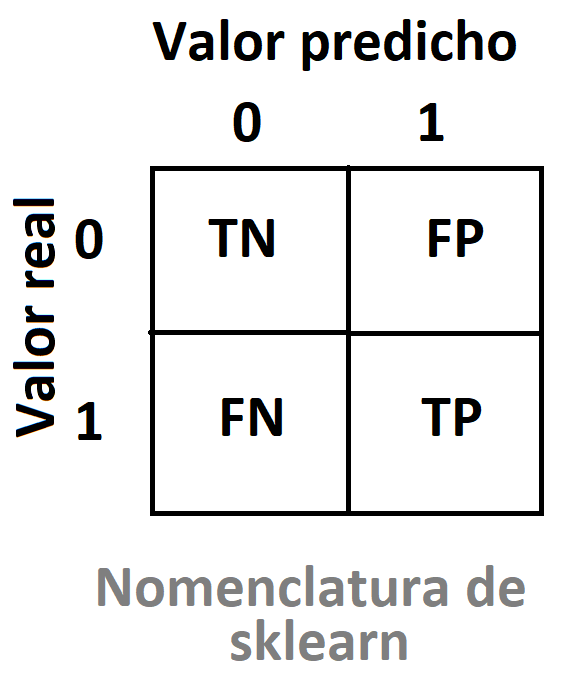

Los valores solicitados los podría calcular partiendo de la matriz de confusión, o podría obtenerlos directamente del [reporte de clasificación](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

In [18]:
# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("Matriz de Confusión para LR:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("Reporte de clasificacion en conjunto de validacion para LR:")
print(classification_report(y_valid, y_predicted, digits=3))

Matriz de Confusión para LR:
[[35  5]
 [ 0 74]]
Reporte de clasificacion en conjunto de validacion para LR:
              precision    recall  f1-score   support

     benigno      1.000     0.875     0.933        40
     maligno      0.937     1.000     0.967        74

    accuracy                          0.956       114
   macro avg      0.968     0.938     0.950       114
weighted avg      0.959     0.956     0.955       114



Cálculo manual: (Completar con los valores correctos)

- Especificidad: $0.875$. 
- Sensibilidad: $1.000$. 

---------

Cálculo según el reporte de clasificación:

In [17]:
# muestra un reporte de la clasificacion en validacion
print("Reporte de clasificacion en conjunto de validacion para LR:")
print(classification_report(y_valid, y_predicted, digits=3))

Reporte de clasificacion en conjunto de validacion para LR:
              precision    recall  f1-score   support

     benigno      1.000     0.875     0.933        40
     maligno      0.937     1.000     0.967        74

    accuracy                          0.956       114
   macro avg      0.968     0.938     0.950       114
weighted avg      0.959     0.956     0.955       114



Por lo tanto, según el reporte de clasificación:

- Especificidad: $0.875$. 
- Sensibilidad: $1.000$.

Los valores deberían coincidir con los calculados manualmente.

#### 5) Indique la cantidad de muestras que caen en la categoría de error de tipo 1, y de tipo 2: <font color='red'>1 punto</font>

In [20]:
# por comodidad de lectura, volvemos a mostrar la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("Matriz de Confusión para LR:")
print(confusion_matrix(y_valid, y_predicted))

Matriz de Confusión para LR:
[[35  5]
 [ 0 74]]


- Error de tipo 1: 5
- Error de tipo 2: 0

#### 6) Repita el análisis anterior, siguiendo las 4 etapas indicadas (1 punto por cada etapa): <font color='red'>4 puntos</font>

Repita los pasos anteriores (entrenamiento de los mismos 4 algoritmos de clasificación usando CV, bajo las mismas condiciones e hiperparámetros), pero esta vez haciendo estandarizacion de los atributos de entrada, para que los datos tengan promedio 0 y desviación estándar 1. (Tip: entrene pipelines StandardScaler() - Algoritmo de ML). Comente si los resultados de los algoritmos cambian significativamente en relacion a no preprocesar los atributos


Creación de los pilelines: `StandardScaler()` + Algoritmo de ML para Clasificación:

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

pipelines = []
pipelines.append(('LR', make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))))
pipelines.append(('KNN', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))))
pipelines.append(('CART', make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=None))))
pipelines.append(('SVM', make_pipeline(StandardScaler(), SVC())))

Evaluación de los pipelines con 10-fold-CV:

In [22]:
# Evaluamos cada pipeline de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7   
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada pipeline en crosvalidacion
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(pipelinename)
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

LR: 0.9638890980195327 (0.028095528679687443)
KNN: 0.9524109723776141 (0.03595639476210352)
CART: 0.9175967143662046 (0.05102727121918831)
SVM: 0.9615079619986909 (0.022475863854626892)


Boxplot de los resultados:

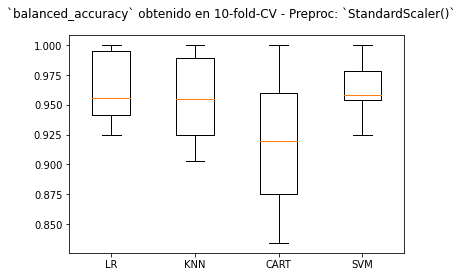

In [23]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los pipelines evaluados
fig = plt.figure()
fig.suptitle('`balanced_accuracy` obtenido en 10-fold-CV - Preproc: `StandardScaler()`')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Selección del mejor algoritmo: SVM

#### 7) Usando toda la data de entrenamiento, ajuste un modelo con el algoritmo identificado en el paso anterior, pero esta vez con el preprocesamiento de `StandardScaler()`. Además, muestre los resultados indicados: <font color='red'>3 puntos</font>

De la grafica anterior se selecciona SVM para tratar con los datos de entrenamiento y validación

In [24]:
# Reentrena el pipeline con SVM sobre los datos de entrenamiento y lo prueba en el conjunto de validación
model = make_pipeline(StandardScaler(), SVC(class_weight='balanced'))
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

Muestre el balanced accuracy score, la matriz de confusión y el reporte de clasificación en validación:

In [26]:
# predice el target en el conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
print("Matriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("Reporte de clasificacion en conjunto de validacion:")
print(classification_report(y_valid, y_predicted, digits=3))

Balanced Accuracy score: 0.9875
Matriz de Confusión:
[[39  1]
 [ 0 74]]
Reporte de clasificacion en conjunto de validacion:
              precision    recall  f1-score   support

     benigno      1.000     0.975     0.987        40
     maligno      0.987     1.000     0.993        74

    accuracy                          0.991       114
   macro avg      0.993     0.988     0.990       114
weighted avg      0.991     0.991     0.991       114



#### 8) ¿Los resultados del mejor algoritmo en data de validacion son mejores que los encontrados en la pregunta 3 (mismo algoritmo pero sin preprocesamiento)? Justifique: <font color='red'>1 punto</font>

Comentario: Los resultados mejoran ya que se obtienen valores más altos en cuanto a precisión, recall y F1 score

#### 9) Aplique otra metodología válida de pre-procesamiento en los atributos de entrada. Para ello, repita el análisis anterior, siguiendo las 3 etapas indicadas (1 punto por cada etapa): <font color='red'>3 puntos</font>

1. Selección de la nueva metodología de preprocesamiento
2. Creación de los pilelines: Pasos de preprocesamiento + Algoritmo de ML para Clasificación & Evaluación de los pipelines con 10-fold-CV
3. Boxplot de los resultados & Selección del mejor algoritmo

Por ejemplo, un preprocesamiento `MinMaxScaler()`, seguido de un preprocesamiento `StandardScaler()` no sería válido.

In [29]:
pipelines = []
pipelines.append(('LR', make_pipeline(MinMaxScaler(), LogisticRegression(solver='liblinear'))))
pipelines.append(('KNN', make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=5))))
pipelines.append(('CART', make_pipeline(MinMaxScaler(), DecisionTreeClassifier(max_depth=None))))
pipelines.append(('SVM', make_pipeline(MinMaxScaler(), SVC())))

standardizer = StandardScaler()
X_std = standardizer.fit_transform(X)

In [30]:
test_size = 0.20
seed = 7
X_train_std, X_valid, y_train, y_valid = train_test_split(X_std, y, test_size=test_size, random_state=seed)      

print('Training: %d ejemplos. Validation: %d ejemplos' % (len(y_train), len(y_valid)))

Training: 455 ejemplos. Validation: 114 ejemplos


In [31]:
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7   
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada pipeline en crosvalidacion
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_train_std, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(pipelinename)
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

LR: 0.9621616532101914 (0.03687209811955284)
KNN: 0.9605298534964952 (0.03257207008143378)
CART: 0.9211919664157442 (0.033405092850624485)
SVM: 0.9710656714461063 (0.02346268264800985)


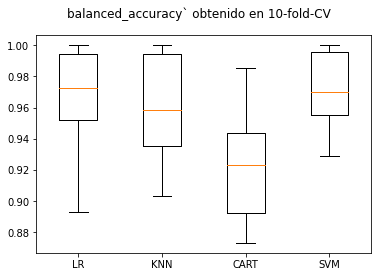

In [32]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los pipelines evaluados
fig = plt.figure()
fig.suptitle('balanced_accuracy` obtenido en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [34]:
# Reentrena el pipeline con SVM sobre los datos de entrenamiento y lo prueba en el conjunto de validación
model = make_pipeline(MinMaxScaler(), SVC(class_weight='balanced'))
model.fit(X_train_std, y_train)

# predice el target en el conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
print("Matriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("Reporte de clasificacion en conjunto de validacion:")
print(classification_report(y_valid, y_predicted, digits=3))

Balanced Accuracy score: 0.975
Matriz de Confusión:
[[38  2]
 [ 0 74]]
Reporte de clasificacion en conjunto de validacion:
              precision    recall  f1-score   support

     benigno      1.000     0.950     0.974        40
     maligno      0.974     1.000     0.987        74

    accuracy                          0.982       114
   macro avg      0.987     0.975     0.981       114
weighted avg      0.983     0.982     0.982       114

